<a href="https://colab.research.google.com/github/hersan19/ENC2022-PI-PG/blob/main/tutorial_ENC_PG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
user = "hersan19"

repo = "ENC2022-PI-PG"

src_dir = "blob"

pyfile = "function_set.py"



url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{pyfile}"

!wget --no-cache --backups=1 {url}

# Bibiliotecas a utilizar
Se instalan bibliotecas que se utilizarán para el ejercicio. 

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install deap
!pip install kornia

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Bibliotecas
Se importan las bibliotecas a utilzar para el manejo de imágenes, clasificadores y programación genética 

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import kornia as K
#Bibliotecas para gráficos
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
# Bibliotecas para el procesamiento de imágenes
import numpy as np 
import skimage
import pandas as pd 
# Bibliotecas para el cómputo evolutivo
import operator 
import math
import random
from deap import base, creator, tools, gp
#Bilbiotecas para datasets
from imblearn.under_sampling import RandomUnderSampler
#Bibliotecas para clasificadores
import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import torch.nn.functional as F
import torch.nn as nn
#Bibliotecas para gp
import networkx as nx
import function_set as fs
from deap import algorithms


from collections import Counter

# Conjuntos de datos
Se agregan los conjuntos de datos a utilizar. CIFAR-10 y MNIST.

In [ ]:
#Función para descargar el conjunto de datos en formato tensor
def get_data_tensor(dataset):
  transform = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Grayscale(1),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     #transforms.Normalize((0.5,), (0.5,), (0.5))
     ])
  
  data = {}
  
  #CIFAR-10 (50,000 train + 10,000 test)
  if dataset == 'CIFAR-10':
    batch_size = 50000
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    dataiter = iter(trainloader)
    images_train, labels_train = dataiter.next() 
    
    batch_size = 10000
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
    dataiter = iter(testloader)
    images_test, labels_test = dataiter.next()

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  
  #MNIST (60,000 train + 10,000 test)
  elif dataset == 'MNIST':
    batch_size = 60000
    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    dataiter = iter(trainloader)
    images_train, labels_train = dataiter.next() 
    
    batch_size = 10000
    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                          download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
    dataiter = iter(testloader)
    images_test, labels_test = dataiter.next()
 
    classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
  
  elif dataset == 'SVHN':
    batch_size = 60000
    trainset = torchvision.datasets.SVHN(root='./data', split="train",
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    dataiter = iter(trainloader)
    images_train, labels_train = dataiter.next() 
    
    batch_size = 10000
    testset = torchvision.datasets.SVHN(root='./data', split="test",
                                          download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
    dataiter = iter(testloader)
    images_test, labels_test = dataiter.next()
 
    classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
  
  #FMNIST (60,000 train + 10,000 test)
  elif dataset == "FMNIST":
    batch_size = 60000
    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    dataiter = iter(trainloader)
    images_train, labels_train = dataiter.next()
    
    batch_size = 10000
    testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                          download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
    dataiter = iter(testloader)
    images_test, labels_test = dataiter.next()

    classes = ('t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle-boot')

  data["train_images"] = images_train
  data["train_labels"] = labels_train
    
  data["test_images"] = images_test
  data["test_labels"] = labels_test

  return data, classes

In [ ]:
#Obtiene datos en formato tensor
# data, classes = get_data_tensor('SVHN')
# data, classes = get_data_tensor('MNIST')
data, classes = get_data_tensor('FMNIST')

train_images = data["train_images"]
train_labels = data["train_labels"]

test_images = data["test_images"]
test_labels = data["test_labels"]

In [ ]:
train_images.max(), train_labels.max(), test_images.max(), test_labels.max()

(tensor(1.), tensor(9), tensor(1.), tensor(9))

In [ ]:
train_images.min(), train_labels.min(), test_images.min(), test_labels.min()

(tensor(0.), tensor(0), tensor(0.), tensor(0))

In [ ]:
#Función para obtener un conjunto de datos balanceado en clases
def get_data_balanced(images, labels, no_examples_per_class):
  #Conforma vector de píxeles
  images_t = images.flatten(start_dim=1)

  #Genera diccionarcio
  def mk_dict_balance(no_examples, no_classes):
    dic={}
    for i in range(no_classes):
      dic[i]=no_examples
    return dic
  
  #A partir de un vector devuelve una imagen de tamaño "size como tupla"
  def vector2img(vector, size):
    ch=3 if vector.shape[1]%3==0 else 1
    return vector.view(len(vector), ch, size[0], size[1])

  #Genera dataset balanceado
  balanced = mk_dict_balance(no_examples_per_class, 10)
  under_sampler = RandomUnderSampler(random_state=42, sampling_strategy=balanced)#"auto"
  X_res, y_res = under_sampler.fit_resample(images_t, labels)
  #print(Counter(y_res))

  #Recupera formato de tensor [B C H W]
  size = (images.shape[2], images.shape[3])
  images_balanced = vector2img(torch.from_numpy(X_res), size)
  labels_balanced = torch.from_numpy(y_res)

  return images_balanced, labels_balanced

In [ ]:
#Obtiene un dataset balanceado: 80 imágenes por clase para entrenamiento y 20 por clase para prueba
train_images, train_labels = get_data_balanced(train_images, train_labels, 80)
test_images, test_labels = get_data_balanced(test_images, test_labels, 20)

In [ ]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

(torch.Size([800, 1, 28, 28]),
 torch.Size([800]),
 torch.Size([200, 1, 28, 28]),
 torch.Size([200]))

In [ ]:
train_images.max(), train_labels.max(), test_images.max(), test_labels.max()

(tensor(1.), tensor(9), tensor(1.), tensor(9))

In [ ]:
train_images.min(), train_labels.min(), test_images.min(), test_labels.min()

(tensor(0.), tensor(0), tensor(0.), tensor(0))

# Muestra imágenes
Se crea una función que permite visualizar los datos almacenados en el tensor *train_images*

In [ ]:
#Funciones para mostrar una imagen
def vector2img(vector, size):
  ch=3 if vector.shape[1]%3==0 else 1
  return vector.view(len(vector), ch, size[0], size[1])

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Tomamos 40 imágenes del conjunto de entrenamiento y las mostramos en un *grid* de 5 x 8

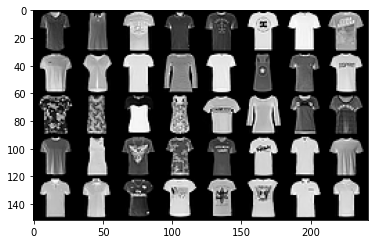

In [ ]:
grid = torchvision.utils.make_grid(train_images[:40], nrow = 8, padding = 2)
imshow(grid)

Muestra una sola imagen

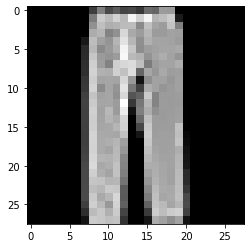

trouser


In [ ]:
# Muestra un ejemplo de la imagen que compone el conjunto de datos
idx=100
grid=torchvision.utils.make_grid(train_images[idx,:,:,:])
imshow(grid)
print(classes[train_labels[idx]])

# Funciones morfológicas
La biblioteca Kornia ofrece un conjunto de funciones y operaciones para resolver problemas de visión por computadora, redes neuronales con soporte para el cómputo en tarjetas gráficas.
Para más información: https://github.com/kornia/kornia

Las funciones consideradas se encuentran en el archivo "function_set.py". Se compone por las siguientes funciones.

*   Funciones morfológicas
>* Erosión
>* Dilatación
>* Apertura o *Opening*
>* Cierre o *Closing*
*   Detección de bordes
>* Sobel
>* LaPlaciano
>* Gradiente
*   Funciones aritméticas
>* Suma (2 o 3 imágenes)
>* Raíz cuadrada
*   Filtrado y transformaciones de intensidad
>* Ecualización de histograma
>* Ajuste de brillo
>* Gaussiano

Se muestra a continuación el efecto que se tiene al aplicar dichas funciones.


## Funciones morfológicas
Selecciona un conjunto de imágenes del conjunto de entrenamieto almacenado en el tensor con dimensiones [B, C, H, W], donde B se refiere al tamaño del lote, C al número de canales, H y W a la altura y ancho de las imágenes, respectivamente.

In [ ]:
images = train_images.clone()

Se aplican las funciones morfológicas

In [ ]:
images_ero = fs.Erosion(images)
images_dil = fs.Dilation(images)
images_ope = fs.Opening(images)
images_clo = fs.Closing(images)

y se muestra el efecto de aplicar las funciones morfológicas a un conjunto de imágenes en particular:

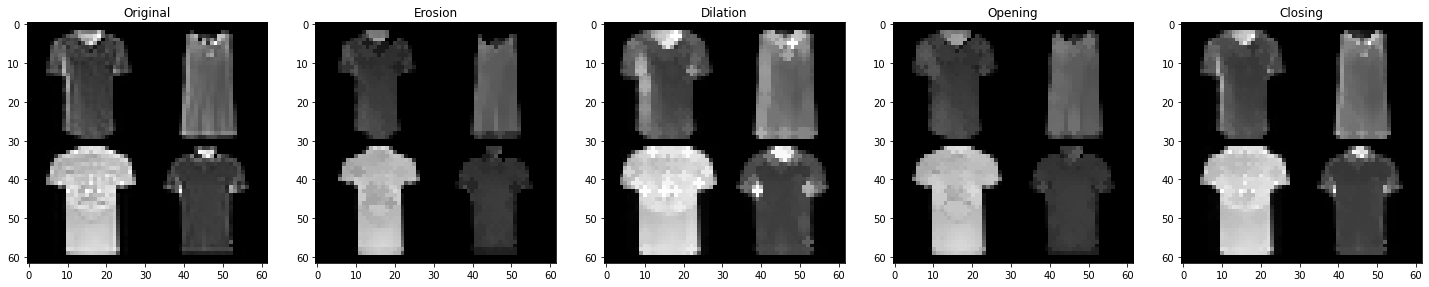

In [ ]:
# idx=50
morphologicals = [images_ero, images_dil, images_ope, images_clo]
# grids=[torchvision.utils.make_grid(morph[idx,:,:,:]) for morph in morphologicals]
grids=[torchvision.utils.make_grid(morph[:4], nrow = 2, padding = 2) for morph in morphologicals]
# grids.insert(0, torchvision.utils.make_grid(images[idx,:,:,:]))
grids.insert(0, torchvision.utils.make_grid(images[:4], nrow = 2, padding = 2))
grids=[np.transpose(grid.numpy(), (1,2,0)) for grid in grids]
titles=['Original', 'Erosion', 'Dilation', 'Opening', 'Closing']

f = plt.figure(figsize=(25,25))
for i in range(len(titles)):
  f.add_subplot(1, len(titles), i+1)
  plt.title(titles[i])
  plt.imshow(grids[i])

## Funciones de detección de bordes
Se aplican las funciones de detección de bordes: Sobel, LaPlaciano y Gradiente al conjunto de imágenes

In [ ]:
images_sobel = fs.Sobel(images)
images_lapl = fs.LaPlacian(images)
images_grad = fs.Gradient(images)

Nuevamente, se muestra el efecto de aplicar dichas funciones al conjunto de datos

tensor(0.4815)


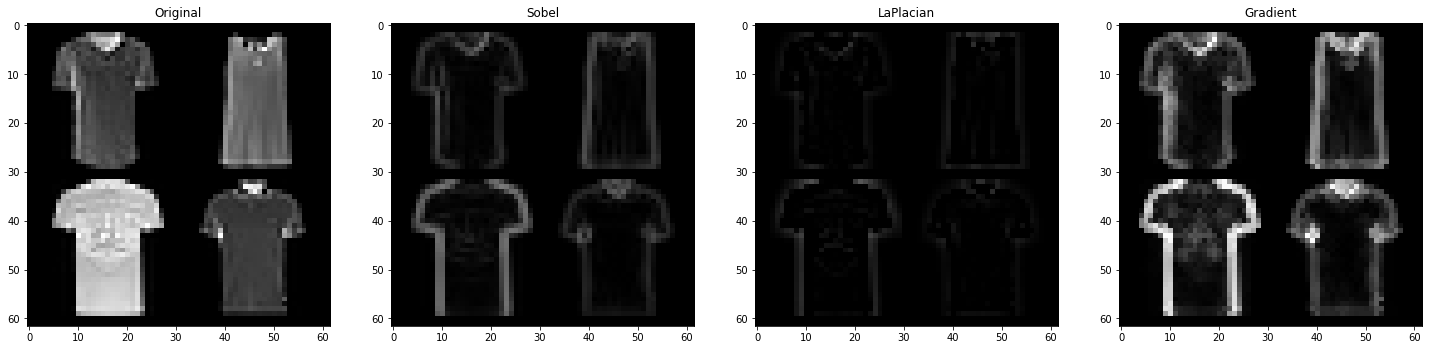

In [ ]:
edges = [images_sobel, images_lapl, images_grad]
grids=[torchvision.utils.make_grid(edge[:4], nrow = 2, padding = 2) for edge in edges]
print(grids[0].max())
grids.insert(0, torchvision.utils.make_grid(images[:4], nrow = 2, padding = 2))
grids=[np.transpose(grid.numpy(), (1,2,0)) for grid in grids]
titles=['Original', 'Sobel', 'LaPlacian', 'Gradient']

f = plt.figure(figsize=(25,25))
for i in range(len(titles)):
  f.add_subplot(1, len(titles), i+1)
  plt.title(titles[i])
  plt.imshow(grids[i])

## Funciones Aritméticas
Se aplican las funciones artiméticas a un conjunto de imágenes. Se considera la función suma con de aridad 2 y 3 y raíz cuadrada

In [ ]:
input1 = fs.Erosion(images)
input2 = fs.Opening(images)
input3 = fs.Sobel(images)
images_add2 = fs.suma_imgs2(input1, input2)
images_add3 = fs.suma_imgs3(input1, input2, input3)
images_sqrt = fs.sqrt(input1)

Se muestra el efecto de sumar 2 y 3 imágenes distintas entre sí. Para cada función, el conjunto de imágenes se ha dividido en 2 y 3 subconjuntos, respectivamente.

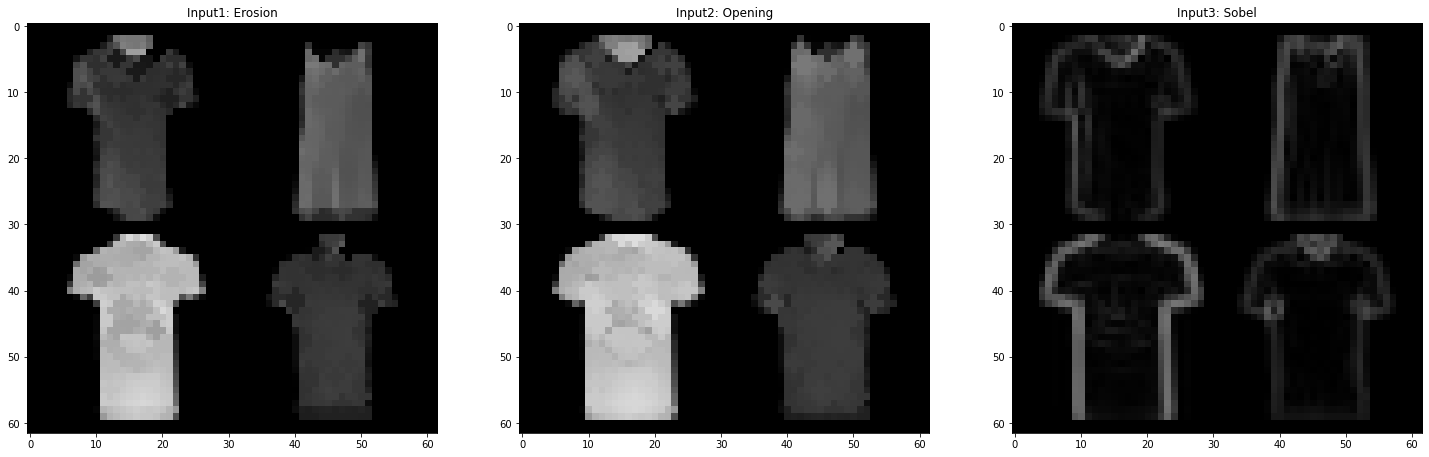

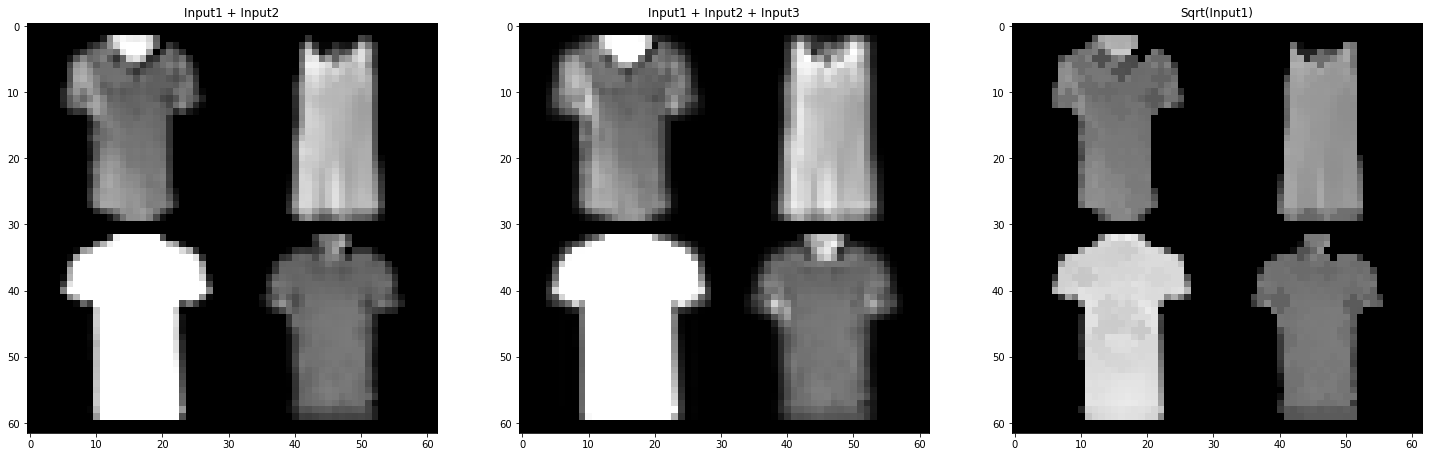

In [ ]:
inputs=[input1, input2, input3]
arithms = [images_add2, images_add3, images_sqrt]
grids_inp=[torchvision.utils.make_grid(inp[:4], nrow = 2, padding = 2) for inp in inputs]
grids=[torchvision.utils.make_grid(arithm[:4], nrow = 2, padding = 2) for arithm in arithms]

# grids.insert(0, torchvision.utils.make_grid(images[:4], nrow = 2, padding = 2))
grids_inp=[np.transpose(inp.numpy(), (1,2,0)) for inp in grids_inp]
grids=[np.transpose(grid.numpy(), (1,2,0)) for grid in grids]
titles_inp=['Input1: Erosion','Input2: Opening','Input3: Sobel']
titles=['Input1 + Input2', 'Input1 + Input2 + Input3', 'Sqrt(Input1)']

f = plt.figure(figsize=(25,25))
for i in range(len(titles)):
  f.add_subplot(1, len(titles), i+1)
  plt.title(titles_inp[i])
  plt.imshow(grids_inp[i])

f2 = plt.figure(figsize=(25,25))
for i in range(len(titles)):
  f2.add_subplot(1, len(titles), i+1)
  plt.title(titles[i])
  plt.imshow(grids[i])

# Clasificadores
Se generan los clasificadores a utilizar: K-NN, Árbol de decisión, Máquina de soporte vectorial, Multiperceptron

In [ ]:
#Clasificador MultiPerceptron Pytorch
class MLP(nn.Module):
  def __init__(self, in_channels, hidden_channels, 
               no_epochs, lr):
    super(MLP, self).__init__()
    self.mlp = torchvision.ops.MLP(in_channels, hidden_channels, activation_layer=torch.nn.ReLU)
    self.no_epochs=no_epochs
    self.lr=lr

  def forward(self, x):
    x = self.mlp(x)
    return x

In [ ]:
#Clasificadores
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

names = [
    "KNN",
    "Decision Tree",
    "MLP",
    "SVM"
]

classifiers = [
    KNeighborsClassifier(1),
    DecisionTreeClassifier(max_depth=5),
    MLP(784,[1000,100,10],
        no_epochs=200, lr=0.01),
    SVC(kernel="rbf")
]

clfs_names=dict(zip(names,classifiers))

# Programación Genética
## Conjunto de funciones y terminales
Se agrega el conjunto de funciones y terminales.
Las funciones a utilizar se toman del script "function_set.py"
Dichas funciones se encargar de realizar el procesamiento digital del conjunto de imágenes. 

En total se encuentran 13 funciones, las cuales 


In [ ]:
#Conjunto de funciones
pset = gp.PrimitiveSet("main", 1)
pset.addPrimitive(fs.Erosion, 1, "ero")
pset.addPrimitive(fs.Dilation, 1, "dil")
pset.addPrimitive(fs.Closing, 1, "clo")
pset.addPrimitive(fs.Opening, 1, "op")
pset.addPrimitive(fs.Gradient, 1, "grad")
# pset.addPrimitive(fs.Gaussian_blur_2d, 1, "g_blur")
pset.addPrimitive(fs.En_adbright, 1, "bright")
pset.addPrimitive(fs.En_equal, 1, "h_eq")
pset.addPrimitive(fs.suma_imgs2, 2, "sum2")
pset.addPrimitive(fs.suma_imgs3, 3, "sum3")
# pset.addPrimitive(fs.resta_imgs, 2, "sub")
pset.addPrimitive(fs.sqrt,1,"sqrt")
pset.addPrimitive(fs.Sobel, 1, "sobel")
pset.addPrimitive(fs.LaPlacian, 1, "laplace")

#Conjunto de terminales
pset.renameArguments(ARG0='img')

Se crea una función que permita visualizar el árbol correspondiente a un individuo generado por PG con base en el conjunto de funciones y terminales considerado

In [ ]:
#Función para graficar/visualizar el árbol
def plt_ind(ind):
    tree=gp.PrimitiveTree(ind)
    nodes, edges, labels = gp.graph(tree)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    
    pos = nx.nx_agraph.graphviz_layout(g, prog="dot")
    
    nx.draw_networkx_nodes(g, pos)
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels)
    plt.axis('off')
    plt.show()
    return

## Árbol sintáctico generado con PG
La biblioteca DEAP ofrece un meta-constructor de clases que permite generar clases y sus atributos. Toma como parámetros el nombre de la clase, la clase base de la que toma herencia y los atributos declarados al generar instancias de esta clase.

Particularmente, tomamos un problema de maximización mono-objetivo, señalado por el parámetro *weights=(1.0)*. En caso de tratarse de un problema de minimización se señala como *weight=(-1.0)*. 

Los individuos tendrán un atributo denominado *fitness* que heredan sus propiedades de un árbol primitivo.

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

Cada individuo puede representarse con un árbol sintáctico que toma como entrada una imagen y genera una salida a partir de una composición de funciones.
A continuación se muestra la salida obtenida al considerar un árbol sintáctico generado aleatoriamente.

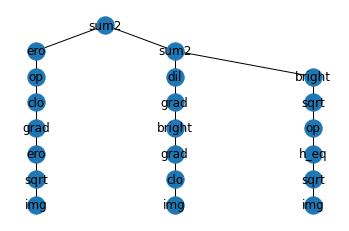

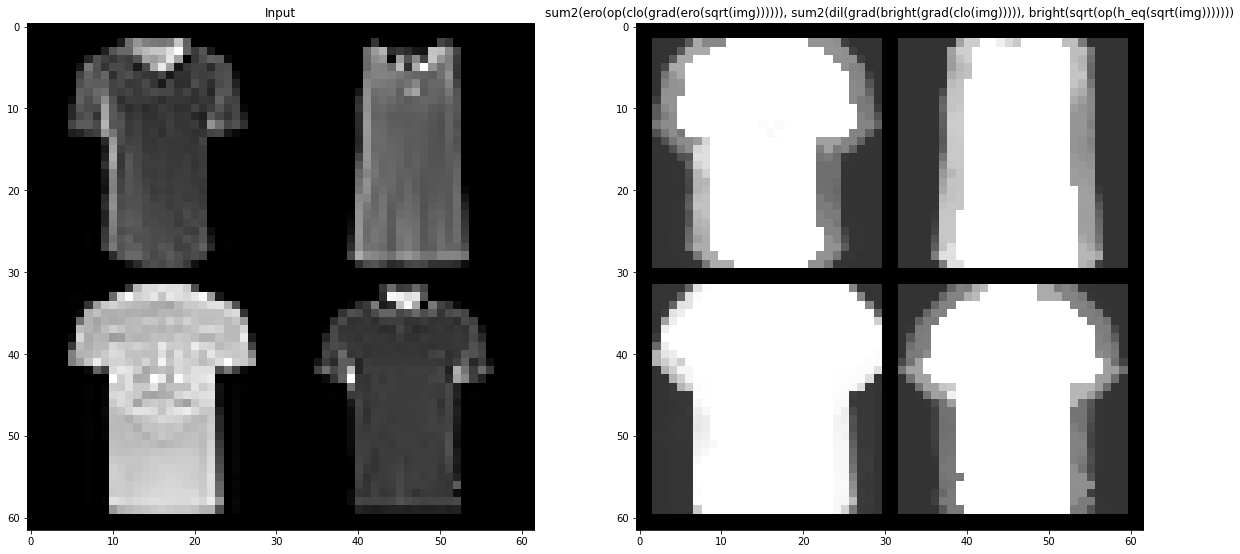

In [ ]:
syntax_tree = 'sum2(ero(op(clo(grad(ero(sqrt(img)))))), sum2(dil(grad(bright(grad(clo(img))))), bright(sqrt(op(h_eq(sqrt(img)))))))'
pt = gp.PrimitiveTree.from_string(syntax_tree, pset)
ind = creator.Individual(pt)
plt_ind(ind)

function = gp.compile(ind, pset=pset)
out = function(images)

inp_out=[images, out]
grids=[torchvision.utils.make_grid(io[:4], nrow = 2, padding = 2) for io in inp_out]
grids=[np.transpose(grid.numpy(), (1,2,0)) for grid in grids]
titles=['Input', syntax_tree]

f = plt.figure(figsize=(20,20))
for i in range(len(titles)):
  f.add_subplot(1, len(titles), i+1)
  plt.title(titles[i])
  plt.imshow(grids[i])

## Función de evaluación
La función de evaluación o función de aptitud es la que permite responder a la pregunta *¿qué tan buena es la solución?*

Consiste en evaluar un individuo que permite extraer las características de forma eplicable. Una vez extraídas las características estas son utilizadas como entradas de un modelo de clasificación el cual aprende con el conjunto de imágenes de entrenamiento y al evaluarlo en el conujunto de validación devuelve la tasa de clasificación. Los clasificadores considerados son: K-NN, árbol de decisión, Multiperceptrón y Máquina de Soporte Vectorial.

In [ ]:
def train(clf, inputs, labels):
  if isinstance(clf, (KNeighborsClassifier, MLPClassifier, DecisionTreeClassifier, SVC)):
    inputs = inputs.to("cpu")
    labels = labels.to("cpu")
    clf.fit(inputs, labels)

  elif isinstance(clf, nn.Module):
    #Optimizador y función de costo para entrenar el modelo MLP
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(clf.parameters(), lr=clf.lr)
    device = "cuda:0"
    clf = clf.to(device)
    clf.train()
    inputs = inputs.to(device)
    labels = labels.to(device)

    losses = []
    for i in range(clf.no_epochs):
      preds = clf(inputs)
      # preds = preds.to(device)
      loss = loss_fn(preds.to(device), labels)
      losses.append(loss)
      # print(f'Epoca: {i:2}  loss: {loss.item():10.8f}')
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    del preds
    # del inputs
    # del labels
    del optimizer
    torch.cuda.empty_cache()

  return clf

def validate(clf, inputs, labels):
  if isinstance(clf, (KNeighborsClassifier, MLPClassifier, DecisionTreeClassifier, SVC)):
    inputs = inputs.to("cpu")
    labels = labels.to("cpu")
    return clf.score(inputs,labels)

  elif isinstance(clf, nn.Module):
    # clf.eval()
    predicciones=[]
    device = "cuda:0"
    with torch.no_grad():
      clf=clf.to(device)
      inputs=inputs.to(device)
      labels=labels.to(device)

      for val in inputs:
          pred = clf.forward(val)
          predicciones.append(pred.argmax().item())

    inputs = inputs.to("cpu")
    labels = labels.to("cpu")
    clf = clf.to("cpu")

    df = pd.DataFrame({'Label': labels, 'Pred': predicciones})
    df['Correcto'] = ["Si" if corr == predicciones else "No" for corr, predicciones in zip(df['Label'], df['Pred'])]
    
    predicciones=np.asarray(predicciones)
    labels = np.asarray(labels)
    matriz=confusion_matrix(labels,predicciones)
    score = accuracy_score(labels, predicciones)
    # print(matriz, score)

    del predicciones
    del inputs
    del labels
    torch.cuda.empty_cache()

    return score

def evaluate(ind, clf_name="Neural Net"):
  function = toolbox.compile(ind)
  train_features = function(train_images)
  test_features = function(test_images)

  #Convierte cada imagen  del conjunto de entrenamiento y prueba en un vector de entradas al modelo
  train_features = train_features.flatten(start_dim=1)
  test_features = test_features.flatten(start_dim=1)

  #Selecciona el modelo de clasificación
  if clf_name=="KNN":
    clf = clfs_names[clf_name]
  elif clf_name=="Decision Tree":
    clf = clfs_names[clf_name]
  elif clf_name=="MLP":
    clf = clfs_names[clf_name]
  elif clf_name == "SVM":
    clf = clfs_names[clf_name]
  else:
    print("Clasificador no seleccionado")

  #Entrena modelo de clasificación
  clf = train(clf, train_features, train_labels)

  #Valida modelo de clasificación
  score = validate(clf, test_features, test_labels)

  return score,

In [ ]:
#Toolbox de DEAP GP
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=5, max_=12)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=2, max_=8)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# toolbox.register("evaluate", evaluate, clf_name="KNN")
# toolbox.register("evaluate", evaluate, clf_name="Decision Tree")
# toolbox.register("evaluate", evaluate, clf_name="MLP")
toolbox.register("evaluate", evaluate, clf_name="SVM")

Se visualiza un ejemplo de árbol generado por PG:

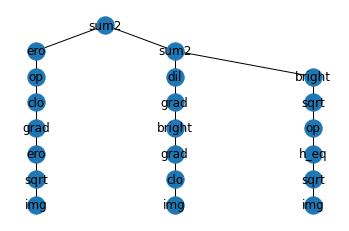

sum2(ero(op(clo(grad(ero(sqrt(img)))))), sum2(dil(grad(bright(grad(clo(img))))), bright(sqrt(op(h_eq(sqrt(img)))))))


(0.455,)

In [ ]:
ind=toolbox.individual()
plt_ind(ind)
print(str(ind))
fitness = evaluate(ind, clf_name = "MLP")
fitness

Se declaran las estadísticas para monitorear durante el proceso evolutivo

In [ ]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

Parámetros del algoritmo evolutivo basado en PG

In [ ]:
no_individuals=2
population = toolbox.population(n=no_individuals)
halloffame = tools.HallOfFame(1)
verbose = True
ngen = 20
cxpb=0.9
mutpb=0.5
elitpb=0.2

Algoritmo con elitismo

In [ ]:
logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + (mstats.fields if mstats else [])

# Evalúa los individuos que no tienen asignado el atributo "fitness"
invalid_ind = [ind for ind in population if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

#Se seleccionan los mejores individuos de la población para conservarlos en la siguiente generación
inds_elit = tools.selBest(population, int(elitpb*no_individuals))

if halloffame is not None:
    halloffame.update(population)

record = mstats.compile(population) if mstats else {}
logbook.record(gen=0, nevals=len(invalid_ind), **record)
if verbose:
    print(logbook.stream)

#Comienza proceso generacional
for gen in range(1, ngen + 1):
    # Selecciona los padres para generar la descendencia
    # offspring = toolbox.select(population, len(population))
    parents = toolbox.select(population, len(population)-int(elitpb*no_individuals))

    # Se aplican los operadores de variación
    offspring = algorithms.varAnd(parents, toolbox, cxpb, mutpb)

    # Evalúa los individuos que no tienen asignado el atributo "fitness"
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Añade a la descendencia los individuos seleccionados por elitismo
    offspring = offspring + inds_elit

    # Actualiza salón de la fama con población generada
    if halloffame is not None:
        halloffame.update(offspring)

    # Remplaza la población con los individuos de la descendencia
    population[:] = offspring

    # population = population + offspring
    # population = tools.selBest(population, k=no_individuals)

    # Añade las estadísticas de la generación al objeto "Logbook"
    record = mstats.compile(population) if mstats else {}
    logbook.record(gen=gen, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)
    
    # Updtate elitism individuals
    inds_elit = tools.selBest(population, int(elitpb*no_individuals))
# return population, logbook

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg  	gen	max  	min	nevals	std    	avg 	gen	max	min	nevals	std    
0  	10    	0.289	0  	0.685	0.1	10    	0.22328	36.4	0  	73 	11 	10    	19.7241
1  	4     	0.416	1  	0.735	0.1	4     	0.25196	22  	1  	42 	9  	4     	9.85901
2  	5     	0.458	2  	0.735	0.095	5     	0.25748	24.1	2  	42 	5  	5     	11.1036
3  	8     	0.5725	3  	0.76 	0.105	8     	0.244082	16.7	3  	32 	3  	8     	10.3058
4  	8     	0.629 	4  	0.76 	0.145	8     	0.207217	12.3	4  	34 	3  	8     	10.2669
5  	8     	0.2325	5  	0.76 	0.1  	8     	0.261278	10.7	5  	25 	3  	8     	9.03383
6  	7     	0.297 	6  	0.76 	0.1  	7     	0.300934	14.2	6  	54 	2  	7     	15.4324
7  	8     	0.232 	7  	0.76 	0.1  	8     	0.264   	15.6	7  	45 	3  	8     	15.1934
8  	7     	0.232 	8  	0.76 	0.1  	7     	0.264   	10  	8  	49 